# Data Import

In [0]:
data_list = pd.read_csv('/content/Data_Entry_2017.csv')

In [0]:
data_list.head()

In [0]:
data_list = data_list.iloc[:, [0,1]]

In [0]:
data_list.describe()

,Image Index,Finding Labels
count,86531,86531
unique,86531,9
top,00025063_000.png,No Finding
freq,1,60361


# Checking distribution of target labels

In [0]:
counts = data_list.groupby(['Finding Labels']).agg({'Image Index':'count'})
counts.sort_values('Image Index', ascending=False, inplace=True)

In [0]:
counts = data_list['Finding Labels'].value_counts()[:10]
counts.sort_values(ascending=True, inplace=True)

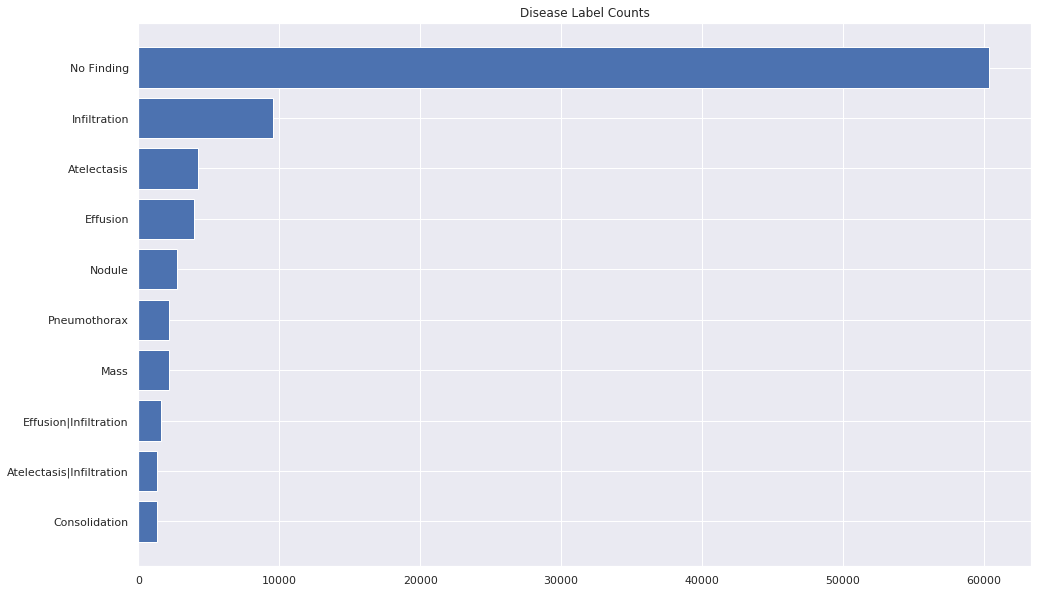

In [0]:
plt.figure(figsize=(16,10))
plt.barh(y=counts.index, width=counts.values)
plt.title('Disease Label Counts')
plt.show()

# Loading Data in Colab

In [0]:
# Download the 56 zip files in Images_png in batches
import urllib.request, urllib.parse, urllib.error

# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading', fn, '...')
    urllib.request.urlretrieve(link, fn)
print("Download complete.")

downloading images_01.tar.gz ...
downloading images_02.tar.gz ...
downloading images_03.tar.gz ...
downloading images_04.tar.gz ...
downloading images_05.tar.gz ...
downloading images_06.tar.gz ...
downloading images_07.tar.gz ...
downloading images_08.tar.gz ...
downloading images_09.tar.gz ...
downloading images_10.tar.gz ...
downloading images_11.tar.gz ...
downloading images_12.tar.gz ...
Download complete.


**Extracting all files**

In [0]:
import tarfile

nums = ['01','02','03','04','05','06','07','08','09','10','11','12']
file_names = ['images_{}.tar.gz'.format(x) for x in nums]

for idx, file in enumerate(file_names):
    with tarfile.open(file, 'r:gz') as tar: 
        print(idx,': Extracting all the files now...') 
        tar.extractall() 
        print(idx,': Done!') 

0 : Extracting all the files now...
0 : Done!
1 : Extracting all the files now...
1 : Done!
2 : Extracting all the files now...
2 : Done!
3 : Extracting all the files now...
3 : Done!
4 : Extracting all the files now...
4 : Done!
5 : Extracting all the files now...
5 : Done!
6 : Extracting all the files now...
6 : Done!
7 : Extracting all the files now...
7 : Done!
8 : Extracting all the files now...
8 : Done!
9 : Extracting all the files now...
9 : Done!
10 : Extracting all the files now...
10 : Done!
11 : Extracting all the files now...
11 : Done!


# Data Preprocessing

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os, shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sm

import cv2
from keras.preprocessing import image
from keras import models, optimizers, layers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


**Initializing data and image directories**

In [0]:
data = pd.read_csv('/content/Data_Entry_2017.csv')

df_dir = '/content/'
img_dir = '/content/images/'

**Defining functions for data preprocessing**

In [0]:
def get_path(img_name, dir):
    return [dir+x for x in img_name]

In [0]:
def data_preprocess(data):
    
    # Split and return class labels
    def unknown(x):
        noreqlist = ['Consolidation','Edema','Emphysema',
                'Fibrosis','Hernia','Pleural_Thickening']
        
        if 'Pneumonia' in x.split('|'):
            return 'Pneumonia'
        elif 'Cardiomegaly' in x.split('|'):
            return 'Cardiomegaly'
        elif 'Pneumothorax' in x.split('|'):
            return 'Pneumothorax'
        elif 'Mass' in x.split('|'):
            return 'Mass'
        elif 'Nodule' in x.split('|'):
            return 'Nodule'
        elif 'Effusion' in x.split('|'):
            return 'Effusion'
        elif 'Atelectasis' in x.split('|'):
            return 'Atelectasis'
        elif (len(x.split('|'))>1) or x in noreqlist:
            return 'Unknown'
        else:
            return x
    
    # Renaming column names
    data = data.loc[:,['Image Index','Finding Labels']]
    data.rename(columns={'Image Index':'images',
                         'Finding Labels':'labels'}, 
                inplace=True)
    
    # Processing labels
    data['labels'] = data['labels'].apply(unknown)
    
    # Down-sampling majority class
    d_lst = data[data['labels'] != 'No Finding']
    Nod_lst = data[data['labels'] == 'No Finding'].sample(10000,random_state=0)
    data = pd.concat([d_lst, Nod_lst], axis=0)
    data.sort_index(inplace=True)
    
    # Removing not required labels
    data = data[data['labels'] != 'Unknown']
    
    # Adding path column for path to each image
    data['path'] = get_path(data['images'], img_dir)
    
    return data

**Splitting data to get train and test set**

In [0]:
data, data_test = train_test_split(data_preprocess(data), 
                                   test_size=0.075, 
                                   random_state=0)

**Function for listing positive counts of each class**

In [0]:
def pos_counts(data):
    dis_dict = {}
    labels = data.labels.value_counts()
    labels.sort_index(inplace=True)
    for id, i in enumerate(labels.index):
        dis_dict[i] = labels.values[id]     
    return dis_dict

In [12]:
dis_dict = pos_counts(data)
dis_dict

{'Atelectasis': 6187,
 'Cardiomegaly': 2535,
 'Effusion': 8724,
 'Infiltration': 8795,
 'Mass': 4791,
 'No Finding': 9227,
 'Nodule': 4629,
 'Pneumonia': 1337,
 'Pneumothorax': 4826}

**Getting list of target labels**

In [0]:
cats_list = list(dis_dict.keys())

**Calculating weights**

In [0]:
def calculating_class_weights(df, true_cols):
    number_dim = np.shape(df[true_cols])[1]
    weights = np.empty([number_dim, 2])
    
    for cnt, i in enumerate(true_cols):
        weights[cnt] = compute_class_weight('balanced', 
                                            [0.,1.], 
                                            df.loc[:, i].values)
    return weights

In [0]:
# One hot encoding all target labels
for i in cats_list:
    data[i] = data['labels'].map(lambda x: 1. if i == x else 0.)
    data_test[i] = data_test['labels'].map(lambda x: 1. if i == x else 0.)

In [0]:
# Getting class-weights for positive value of each class
weights = calculating_class_weights(data, cats_list)[:,1]

**Checking target label distribution post processing**

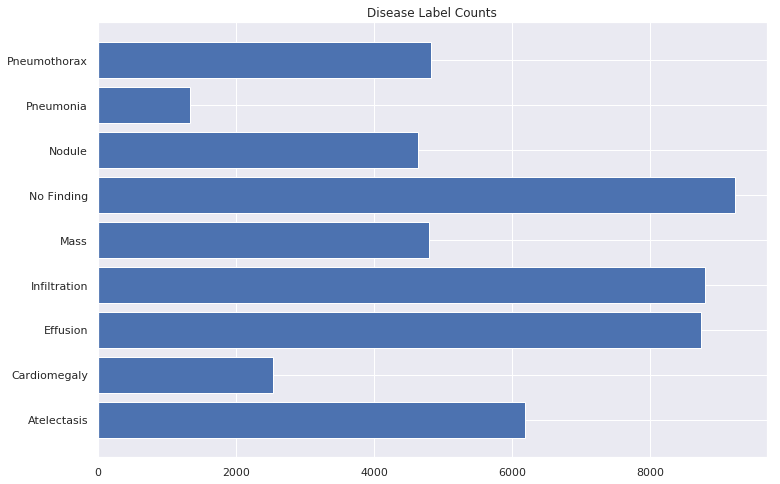

In [0]:
plt.figure(figsize=(12,8))
plt.barh(y=list(dis_dict.keys()), 
         width=list(dis_dict.values()))
plt.title('Disease Label Counts')
plt.show()

**Splitting and Re-sampling**

In [0]:
# Splitting data to get train and validation set
df_train, df_val = train_test_split(data, 
                                    test_size = 0.08, 
                                    random_state = 0, 
                                    stratify=data.labels)

In [0]:
# Re-sampling a small set of data for first phase of training
dfs = []
labs = cats_list

for i in labs:
    n_data = df_train[df_train['labels'] == i].sample(n=3000, 
                                                      replace=True)
    dfs.append(n_data)
    
df_train = pd.concat(dfs, axis=0)
df_train = df_train.sample(len(df_train))
df_train.reset_index(drop=True, inplace=True)

**Setting image size**

In [0]:
height = 224
width = 224

**Generating augmented images in batches for training and validation**

In [0]:
# Setting up DataGenerator for generating augmented images 
img_gen = image.ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   height_shift_range= 0.05,
                                   width_shift_range=0.05,
                                   rotation_range=20,
                                   shear_range=0.1,
                                   fill_mode='reflect',
                                   zoom_range=0.15
                                  )

In [22]:
# DataGenerator for training set
train_gen = img_gen.flow_from_dataframe(dataframe=df_train, 
                                        directory=None, 
                                        x_col='path',
                                        y_col=cats_list,
                                        target_size=(height,width),
                                        color_mode='rgb',
                                        class_mode='other',
                                        batch_size=32, seed=0)

# DataGenerator for validation set
val_gen =  image.ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
                                        dataframe=df_val, 
                                        directory=None, 
                                        x_col='path',
                                        y_col=cats_list,
                                        target_size=(height,width),
                                        color_mode='rgb',
                                        class_mode='other',
                                        batch_size=64, seed=0)

Found 46966 validated image filenames.
Found 4085 validated image filenames.


# Model Building for Multi-Class Classification

**Loading Pretrained base model**

In [0]:
from keras.applications import DenseNet121

conv_base = DenseNet121(weights='imagenet',
                        include_top=False,
                        input_shape=(height, width, 3))

**Freezing first few layers in base**

In [0]:
for i in range(len(model.layers)-13):
    model.layers[i].trainable = False

**Adding our top layers**

In [0]:
x = layers.GlobalAveragePooling2D()(conv_base.output)
x = layers.Dense(9, activation='softmax', name='fc_out')(x)

model = models.Model(inputs=conv_base.input, outputs=x)

In [0]:
model.summary()

**Loading saved weights**

In [0]:
model.load_weights('best_weights_dice_0.3957.hdf5')

**Initializing callbacks**

In [0]:
weight_path="best_weights_dice:{val_dice_coef:.4f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_dice_coef', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = True)

**Defining function for 'Weighted Categorical Cross-Entropy'**

In [0]:
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss   
    return loss

**Defining function for F1-score**

In [0]:
def dice_coef(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    score = (2. * intersection) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1))
    return score

**Compiling and Running model**

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001, decay=1e-10),
              loss=weighted_categorical_crossentropy(weights),
              metrics=[dice_coef])

In [0]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=len(df_train)/(train_gen.batch_size),
                              validation_data=val_gen,
                              validation_steps=len(df_val)/(val_gen.batch_size),
                              epochs=1,
                              callbacks=[checkpoint])

Epoch 1/1
1468/1467 [==============================] - 1347s 917ms/step - loss: 7.3074 - dice_coef: 0.4203 - val_loss: 8.1860 - val_dice_coef: 0.4045

Epoch 00001: val_dice_coef did not improve from 0.40919


**Saving trained model**

In [0]:
model.save_weights('best_weights_dice:0.4065.hdf5')

# Model Performance Validation

In [0]:
def roc_plot(data):
    
    # Initializing DataGenerator for loading data for validation
    gen = image.ImageDataGenerator(rescale=1./255.)
    load = gen.flow_from_dataframe(dataframe=data, 
                                    directory=None, 
                                    x_col='path',
                                    y_col=cats_list,
                                    target_size=(height,width),
                                    color_mode='rgb',
                                    class_mode='other',
                                    batch_size=4096, seed=0)
    
    print('\nLoading data for validation...')
    test_x, test_y = next(load)
    
    print('\nGetting predictions...')
    pred_y = model.predict(test_x, batch_size=32, verbose=True)
    
    print('\nPlotting ROC curves...')
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, c_label) in enumerate(cats_list):
        fpr, tpr, thresholds = roc_curve(test_y[:,idx].astype(int), 
                                         pred_y[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, 
                                                         auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

**Plotting ROC for Validation set**

Found 4085 validated image filenames.

Loading data for validation...

Getting predictions...
4085/4085 [==============================] - 37s 9ms/step

Plotting ROC curves...


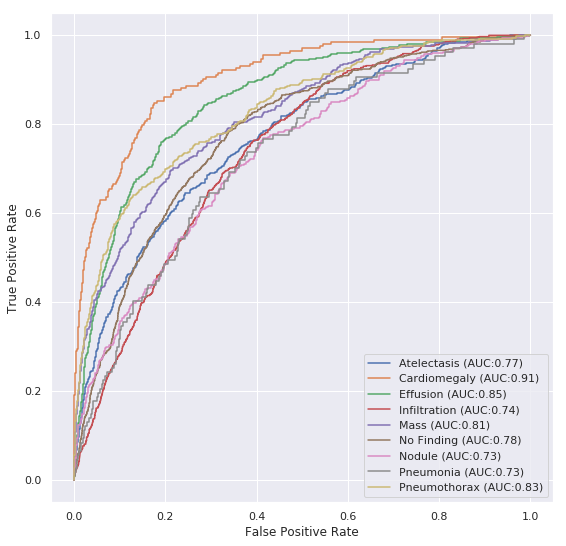

In [34]:
roc_plot(df_val)

**Plotting ROC for Test set**

Found 4140 validated image filenames.

Loading data for validation...

Getting predictions...
4096/4096 [==============================] - 35s 8ms/step

Plotting ROC curves...


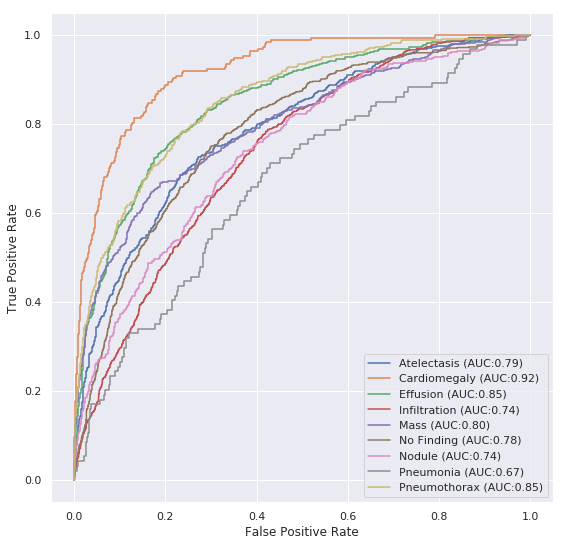

In [35]:
roc_plot(data_test)

# Generating CAMs

In [0]:
# Loading samples with bounding box ground truth
bbox_data = pd.read_csv('/content/BBox_List_2017.csv')
bbox_data = bbox_data.loc[:,:'h]']

In [0]:
bbox_data.rename(columns={'Bbox [x':'x', 
                     'h]':'h',
                     'Image Index':'images',
                     'Finding Label':'labels'}, 
            inplace=True)

In [0]:
bbox_data.labels.replace(to_replace='Infiltrate', 
                         value='Infiltration', 
                         inplace=True)

In [0]:
# Defining function to plot the bounding box ground truths
def plot_bbox(img, disease):
    
    # Loading image
    img_path = '/content/images/'+img
    row = bbox_data[(bbox_data.images == img) & 
                    (bbox_data.labels == disease)]

    # Plotting image with bounding box ground truth         
    plt.figure()
    plt.imshow(cv2.imread(img_path))
    rect = Rectangle((row.x.values[0],row.y.values[0]), 
                     row.w.values[0], row.h.values[0], 
                     fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True label : {disease}')
    plt.show()

In [0]:
from keras.applications.densenet import preprocess_input

# Defining function for grad-cam
def grad_cam(path):
    
    # Loading and preprocessing image as per DenseNet format
    path = '/content/images/'+path
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Making prediction and getting model output for predicted class
    preds = model.predict(x)
    preds = list(preds.flatten())
    class_idx = np.argmax(preds)
    class_output = model.output[:, class_idx]
    
    # Getting final convolution layer and calculating gradients
    last_conv_layer = model.get_layer('bn')
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], 
                         [pooled_grads, 
                          last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(1024):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # Creating heatmap from calculated gradients    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Superimposing heatmap on original image
    img = cv2.imread(path)
    img = cv2.resize(img,(224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    # Plotting heatmap
    plt.figure()
    plt.imshow(superimposed_img)
    plt.grid(False)
    plt.title(f'Prediction : {cats_list[class_idx]}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
# Function to get random samples for testing
def get_random():
    r_images = {}
    for disease in cats_list:
        if disease != 'No Finding':
            name = bbox_data[bbox_data.labels == disease].images.sample(1).values[0]
            r_images[disease] = name

    return r_images

In [0]:
# Function for plotting random images
def all_plots(image_set):
    i = 0
    for true,im in image_set.items():
        plot_bbox(im,true)
        grad_cam(im)
        print('--------------------------------------------')

In [0]:
random_set = get_random()

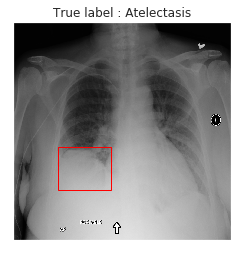

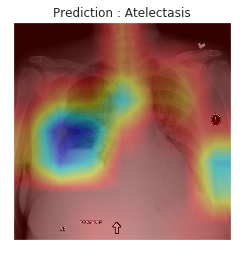

--------------------------------------------


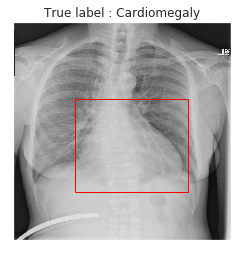

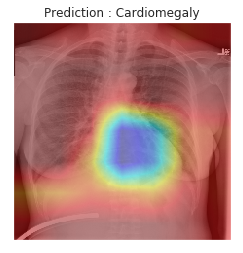

--------------------------------------------


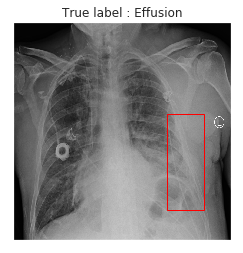

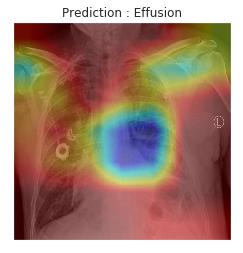

--------------------------------------------


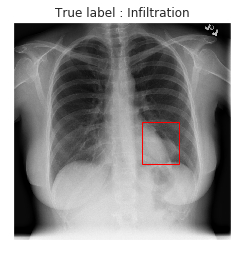

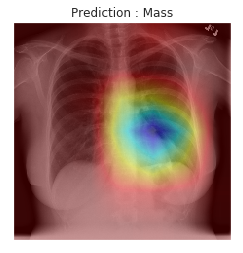

--------------------------------------------


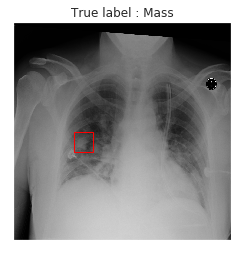

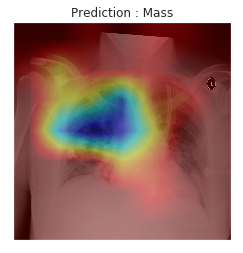

--------------------------------------------


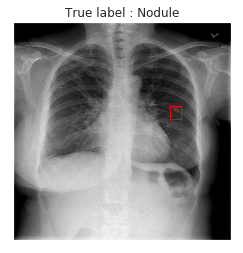

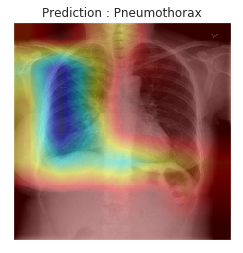

--------------------------------------------


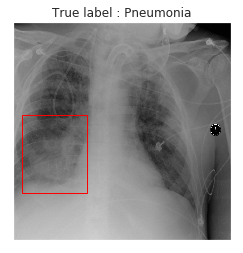

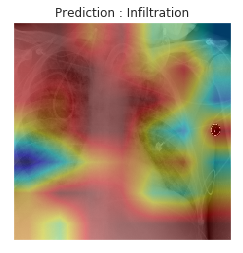

--------------------------------------------


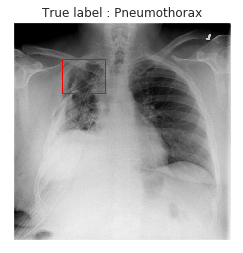

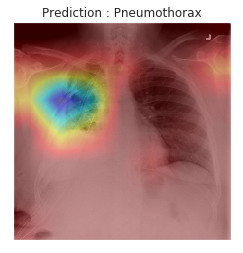

--------------------------------------------


In [0]:
# Plotting test results
all_plots(random_set)